# Learning Goals
This tutorial is a continuation of the [previous TESS NGC4151](https://github.com/tylerapritchard/TESSGI_Tut_NGC4151/blob/main/NGC4151.ipynb) notebook.  In this tutorial we will learn how to:
- Retrieve TESS mission Co-trending Basis Vectors and interpolate them for the FFI images
- Construct a TESS data model based on data from other sources
- Create a Design Matrix for de-trending TESS data from a variety of noise models
- De-trend the TESS light-curve 
- Add a model component to our de-trended lightcurve

# Introduction
From the [previous TESS NGC4151](https://github.com/tylerapritchard/TESSGI_Tut_NGC4151/blob/main/NGC4151.ipynb) notebook we found that our TESS background subtracted lightcurve had some long-timescale behavior that was similar to that seen from the ground.  
![TESS](TESS-ASAS.png)
In this notebook we will apply a series of more complicated lightcurve de-trending corrections, while also calculating a long-timescale flux model from the ground-based ASAS-SN data that we will use to both de-trend the observed TESS data and then re-apply it to recover the long-timescale variability.  


## First, let us recover our data from the previous notebook

In [1]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import MPLSTYLE

import pandas as pd

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern

import pickle

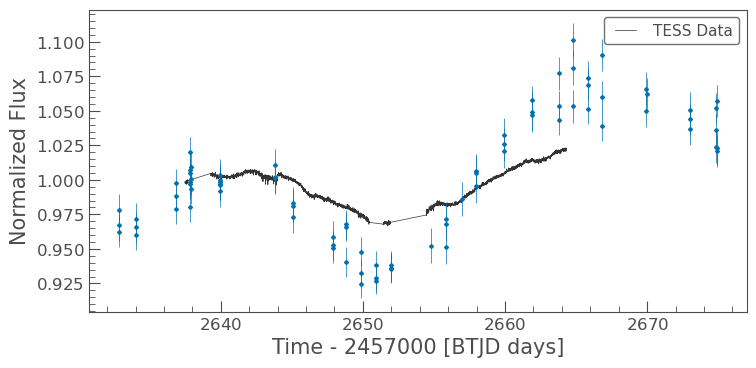

In [2]:
# Read our lc and tpf from the previous notebook
lc=lk.read('NGC4151_lc_bkgsub.fits',quality_bitmask='none')
tpf=lk.read('NGC4151_tpf_bkgsub.fits',quality_bitmask='none')

# Recover our target mask and background mask from the previous notebook
target_mask, bigger_mask = pickle.load(open( "masks.p", "rb" ))

#Re-read the ASAS-SN ground-based g-band data
asas=pd.read_csv('ngc4151_asas.csv')
jdcut=(asas.HJD-2457000 > 2630) & (asas.HJD-2457000 < 2675)
asas=asas[jdcut]

with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')

# From our previous notebook - we're assuming that there are long-baseline (comparable to the sector length) of trends in the TESS data that are real and similar in behavior to that observed by the ground-based ASAS-SN team
As A first reduction,  lets do a detrending reduction with a spline that has a similar number of knots. to the features observed in. the ASAS-SN data

In [4]:
# Obtain the CBVs from the mission
# interpolate from 2min cbvs
ncbvs = 3

cbvc = lk.CBVCorrector(lc, interpolate_cbvs=True)
multiscale1 = cbvc.cbvs[1].interpolate(lc).to_pandas()
multiscale2 = cbvc.cbvs[2].interpolate(lc).to_pandas()
cbvs = np.hstack([np.asarray(multiscale2[multiscale2.columns[2:2+ncbvs]])])

In [7]:
#Estimate the pointing centroids from the TPF
row,col = tpf.estimate_centroids()

# These are cadences where there is non NaN flux inside the aperture.
k = np.isfinite(lc.flux) & np.isfinite(lc.flux_err)

# Design matrix with PCA of the pixels outside the aperture
dm1 = lk.DesignMatrix(np.nan_to_num(tpf.flux[k][:, ~bigger_mask]), name='bkg').pca(2)

# Design matrix with Cotrending Basis Vectors
dm2 = lk.DesignMatrix(cbvs[k], name='cbvs').split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))

knot_list_tess=np.linspace(np.min(lc.time.value+0.0001),
                           np.max(lc.time.value-0.0001),7).tolist()
dm5= lk.designmatrix.create_spline_matrix(lc.time.value,knots=knot_list_tess)

# Combined Design Matrix
dm_spline = lk.DesignMatrixCollection([dm1, dm2,dm5.append_constant()])

array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

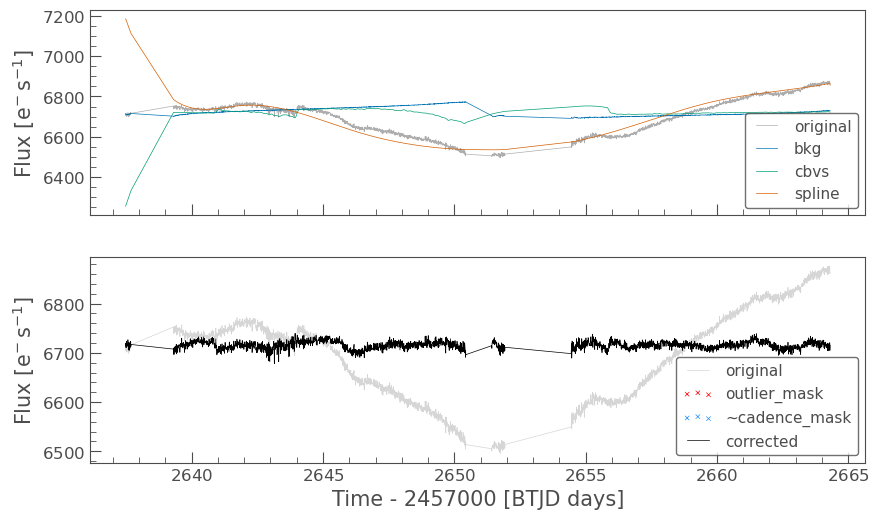

In [8]:
r_spline = lk.RegressionCorrector(lc)
r_spline.correct(dm_spline)
r_spline.diagnose()

## **Now, add our best-fit spline back into the calibrated data**
there's still an edge effect, need to fix, but general idea stands

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

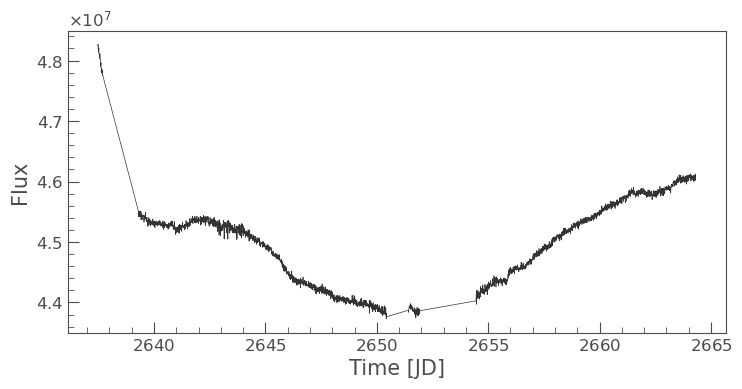

In [11]:
lc_SplineCorrected=lk.LightCurve(time=r_spline.corrected_lc.time.value,
                                 flux=r_spline.corrected_lc.flux.value*r_spline.diagnostic_lightcurves['spline'].flux.value,
                                 flux_err=r_spline.corrected_lc.flux_err.value)
lc_SplineCorrected.plot()

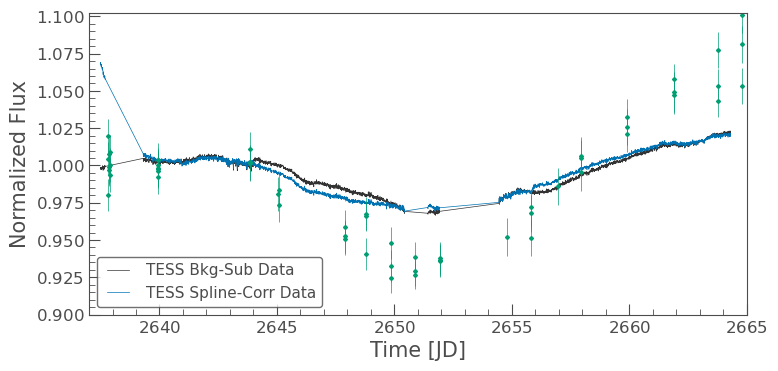

In [15]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS Bkg-Sub Data')
    lc_SplineCorrected.plot(ax=ax,normalize=True, label='TESS Spline-Corr Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.set_xlim(2637,2665)
    ax.set_ylim(0.9,1.1025)

Next, let us create a model of what our TESS lightcurve might look like on long-timescales.  To do this, **we will assume** that it has the same shape as the ASAS-SN normalized light-curve with a multiplicative factor.  To create this we will need a smooth interpolation of the ASAS-SN data with a normalized value at each point.  More complicated models are left to the user and their specific science needs.  

For our interpolation needs, we will use a gaussian process regressor with a RBF kernel and a white noise kernel (to capture the error behavior) of our points.  

In [16]:
# We want to do our regression with the asas-sn data, but predict on the tess epochs
def gpinterp(btjd,flux,tessjd):
    time=np.array(btjd).reshape(-1,1)
    val=np.array(flux)
    kernel =1.0*RBF(length_scale=2, length_scale_bounds=(0.5,1e2)) \
    + WhiteKernel(noise_level=1)
    
    gp=GaussianProcessRegressor(kernel=kernel, alpha=0.0)
    gp.fit(time, val)
    time_pred=tessjd.reshape(-1,1)
    val_pred,val_sigma = gp.predict(time_pred, return_std=True)
    return time_pred.reshape(-1), val_pred, val_sigma

Next, we fit this gaussian process regressor to the ASAS-SN g-band data, while interpolatingits values using the TESS lightcurve. 

In [17]:
# We're padding this a bit to avoid edge effects
sector_mask = (asas.HJD-2457000 > 2630) & (asas.HJD-2457000 < 2675)
gp_t, \
gp_f, \
gp_sig = gpinterp(asas.HJD-2457000, asas.flux/np.median(asas.flux),lc.time.value)

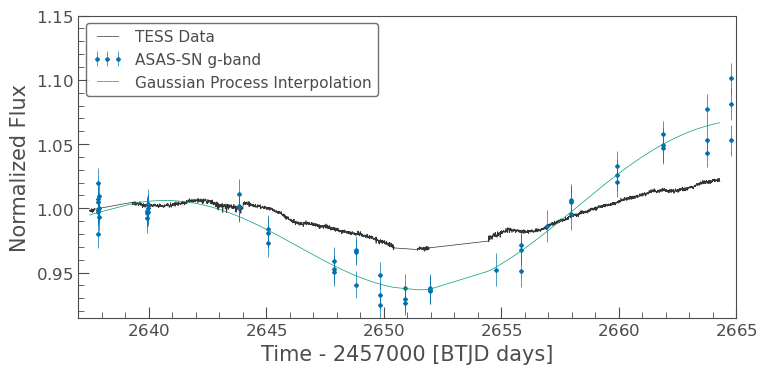

In [18]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f,label='Gaussian Process Interpolation')
    ax.set_ylim(0.915,1.15)
    ax.set_xlim(2637,2665)
    ax.legend(loc=2)

Next, we will use lightkurve to get the missions co-trending basis vectors for the target.  We will interpolate them to the FFI cadence, since they were calculated on the more rapidly observed TESS TICs.  

For a detailed discussion of de-trending vectors and the design matrix, see [Rebekah Hounsell's notebook on TESS-JWST and WASP-43b]

In [19]:
# Obtain the CBVs from the mission
# interpolate from 2min cbvs
ncbvs = 3

cbvc = lk.CBVCorrector(lc, interpolate_cbvs=True)
multiscale1 = cbvc.cbvs[1].interpolate(lc).to_pandas()
multiscale2 = cbvc.cbvs[2].interpolate(lc).to_pandas()
cbvs = np.hstack([np.asarray(multiscale2[multiscale2.columns[2:2+ncbvs]])])

Noteably here, we will add a design matrix, dm4 below, that is our normalized gaussian process interpolated lightcurve

In [20]:
#Estimate the pointing centroids from the TPF
row,col = tpf.estimate_centroids()

# These are cadences where there is non NaN flux inside the aperture.
k = np.isfinite(lc.flux) & np.isfinite(lc.flux_err)

# Design matrix with PCA of the pixels outside the aperture
dm1 = lk.DesignMatrix(np.nan_to_num(tpf.flux[k][:, ~bigger_mask]), name='bkg').pca(2)

# Design matrix with Cotrending Basis Vectors
dm2 = lk.DesignMatrix(cbvs[k], name='cbvs').split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))

# Design matrix with a gp model
dm3 = lk.DesignMatrix(gp_f[k], name='gp_model')

#centroid
dm4 = lk.DesignMatrix(np.nan_to_num(np.vstack([row.value, col.value, row.value*col.value]).T)[k], 
                      name='centroids').split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))
# Combined Design Matrix
dm = lk.DesignMatrixCollection([dm1, dm2,dm3.append_constant()])

array([<AxesSubplot:ylabel='Flux'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>],
      dtype=object)

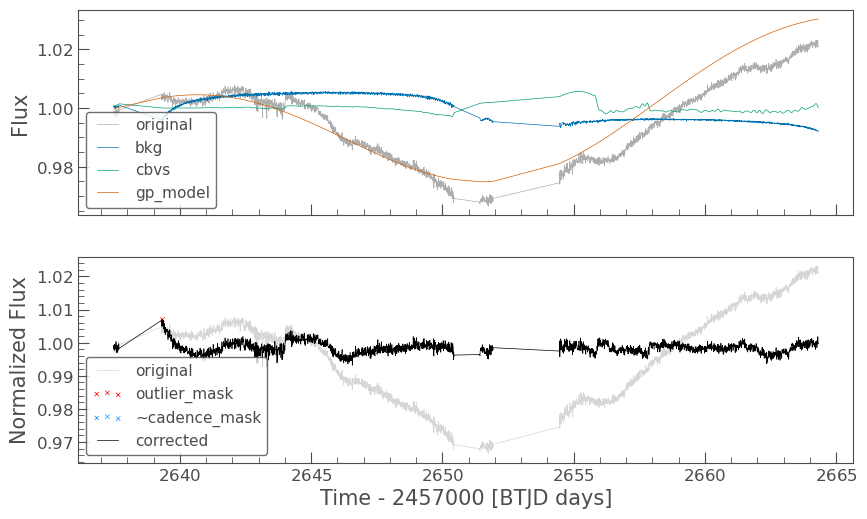

In [21]:
# Correct the light curve using combined design matrix
r = lk.RegressionCorrector(lc[k].normalize())
lc2 = r.correct(dm)

r.diagnose()

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

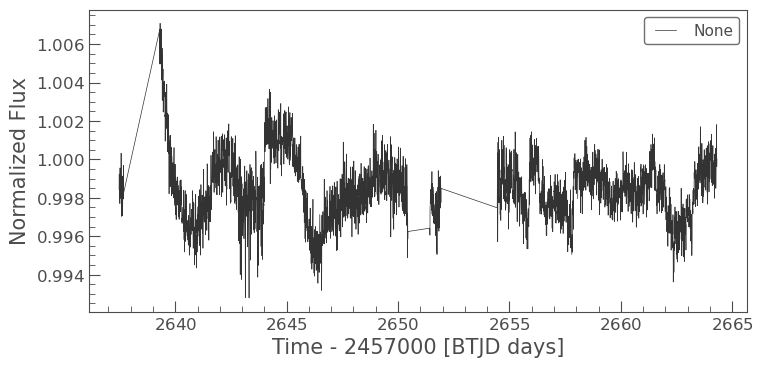

In [22]:
lc2.plot()

In [23]:
r.coefficients

array([ 1.45189496e-01, -2.01926880e-01, -1.33004872e+02, -2.26225436e+01,
        1.11739445e+02, -2.51554178e-02, -9.54999724e-02,  7.14498576e-02,
        9.34699498e-02,  1.33024052e-01, -4.24590683e-01,  4.26914516e-01,
        5.71622116e-01])

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

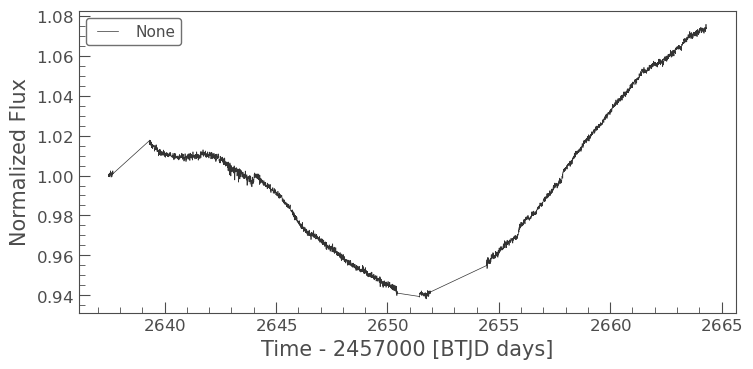

In [24]:
lc3=lc2
lc3.flux=lc2.flux*r.coefficients[11]*gp_f[k]
lc3.plot(normalize=True)

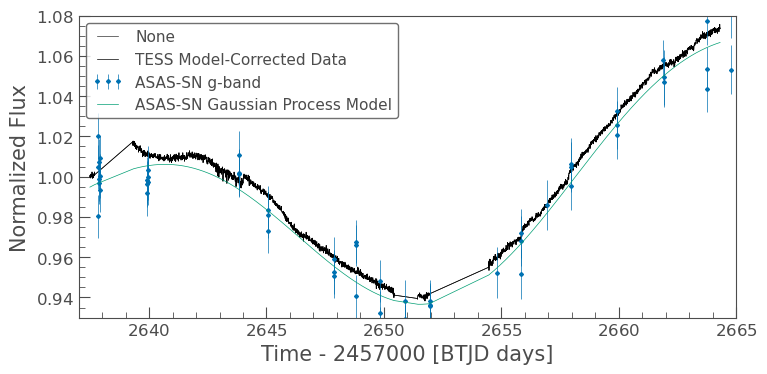

In [25]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc3.plot(ax=ax,normalize=True)
    plt.plot(lc3.time.value,lc3.flux.value/np.nanmedian(lc3.flux.value),color='k',
             label='TESS Model-Corrected Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f, label = 'ASAS-SN Gaussian Process Model')
    ax.set_ylim(0.93,1.08)
    ax.set_xlim(2637,2665)
    ax.legend()

NameError: name 'lc5' is not defined

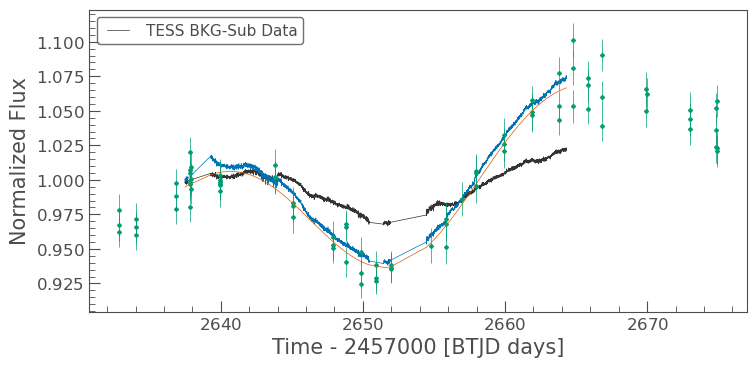

In [27]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS BKG-Sub Data')
    lc_3.plot(ax=ax,normalize=True, label='TESS GP Model-Corrected Data')
    lc_SplineCorrected.plot(ax=ax,normalize=True, label='TESS Spline-Corr Data')

    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f, label = 'ASAS-SN Gaussian Process Model')
    plt.plot(lc5.time.value,lc5.flux.value,
             label='TESS Spline Corrected')    
    ax.set_ylim(0.93,1.08)
    ax.set_xlim(2637,2665)
    ax.legend()

/Users/tapritchard/anaconda3/envs/tessgi/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<AxesSubplot:xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

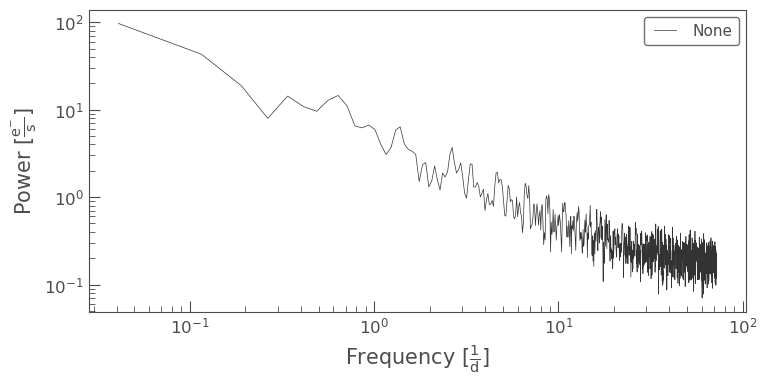

In [26]:
pd2=lc.to_periodogram(method='lombscargle')
pd2=pd2.bin()
pd2.plot(scale='log')

# ** In progress work/Test- comparative fitting**|

In [ ]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f,label='Gaussian Process Interpolation')
    ax.set_ylim(0.915,1.15)
    ax.set_xlim(2637,2665)
    ax.legend(loc=2)

In [ ]:
x=asas.HJD-2457000
y=asas.flux/np.median(asas.flux)
ye=1*(asas.flux_err/np.median(asas.flux))
xi=gp_t
interp_v1=np.interp(xi,x,y)
interp_v2=np.polyval(np.polyfit(x, y, 4, w=1/ye), xi) 
interp_v3=np.polyval(np.polyfit(x, y, 6, w=1/ye), xi) 
interp_v4=np.polyval(np.polyfit(x, y, 5, w=1/ye), xi) 


In [ ]:
### knots=7, including asassn data outsie TESS sector/plotting range
knot_list=[2633,2638,2643,2648,2653,2658,2663,2668]
aslc=lk.LightCurve(time=x,flux=y,flux_err=ye)

dm_spline = lk.designmatrix.create_spline_matrix(x,knots=knot_list)
r_spline = lk.RegressionCorrector(aslc)
r_spline.correct(dm_spline)
r_spline.diagnose()

In [ ]:
### knots=7, including asassn data outsie TESS sector/plotting range
knot_list=[2638,2643,2648,2653,2658,2663,2668]
aslc=lk.LightCurve(time=x,flux=y,flux_err=ye)

dm_spline = lk.designmatrix.create_spline_matrix(x,knots=knot_list)
r_spline = lk.RegressionCorrector(aslc)
r_spline.correct(dm_spline)
r_spline.diagnose()

In [ ]:
kn_min=np.min(lc.time.value+0.0001)
kn_max=np.max(lc.time.value-0.0001)
knot_list_tess=np.linspace(np.min(lc.time.value+0.0001),
                           kn_max=np.max(lc.time.value-0.0001),7).tolist()
dm_tess_spline= lk.designmatrix.create_spline_matrix(xi,knots=knot_list_tess)

r2_spline = lk.RegressionCorrector(lc)
r2_spline.correct(dm_tess_spline)
r2_spline.diagnose()
r2_spline.model_lc.plot()

In [ ]:
#Estimate the pointing centroids from the TPF
row,col = tpf.estimate_centroids()

# These are cadences where there is non NaN flux inside the aperture.
k = np.isfinite(lc.flux) & np.isfinite(lc.flux_err)

# Design matrix with PCA of the pixels outside the aperture
dm1 = lk.DesignMatrix(np.nan_to_num(tpf.flux[k][:, ~bigger_mask]), name='bkg').pca(2)

# Design matrix with Cotrending Basis Vectors
dm2 = lk.DesignMatrix(cbvs[k], name='cbvs').split(list(np.where(np.diff(lc[k].cadenceno) > 100)[0] + 1))

#Combined Design Matrix
dm_ts = lk.DesignMatrixCollection([dm1, dm2,dm_tess_spline.append_constant()])

In [ ]:
# Correct the light curve using combined design matrix
r3 = lk.RegressionCorrector(lc[k].normalize())
lc4 = r3.correct(dm_ts)

r3.diagnose()
lc4.plot()

In [ ]:
diag_lcs=r3.diagnostic_lightcurves

In [ ]:
spl=diag_lcs['spline']

In [ ]:
lc5=lk.LightCurve(time=lc4.time.value,flux=lc4.flux.value*spl.flux.value,flux_err=lc4.flux_err.value)
lc5.plot()

In [ ]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True, label='TESS BKG-Sub Data')
    plt.plot(lc3.time.value,lc3.flux.value/np.nanmedian(lc3.flux.value),
             label='TESS GP Model-Corrected Data')
    ax.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.errorbar(gp_t,gp_f, label = 'ASAS-SN Gaussian Process Model')
    plt.plot(lc5.time.value,lc5.flux.value,
             label='TESS Spline Corrected')    
    ax.set_ylim(0.93,1.08)
    ax.set_xlim(2637,2665)
    ax.legend()